In [336]:
import pandas as pd
import glob
import os
import numpy as np
import datetime as datetime

def listPatternFiles(searchDir, pattern):
    files = glob.glob(os.path.join(searchDir, pattern), recursive = True)
    return files

#Read the hourly power data:

today = datetime.date.today()
tYear = today.year
tMonth = today.month
tDay = today.day

pattern = 'Daily_'+str(tYear)+str(tMonth)+str(tDay)+'*HourlyReleveld.csv'
searchDir = 'I:/BU Portfolio Analytics/Market Analysis/Power/Models & Tools/Merit Order/PDP/Summary Outputs/'

HourlyData = pd.read_csv(listPatternFiles(searchDir, pattern)[0], sep = ";")

#Process the format of daily power data and grabbing as of today-dates only:

HourlyData['VALUEDATETIME'] = pd.to_datetime(HourlyData['VALUEDATETIME'])
HourlyData = HourlyData[HourlyData['VALUEDATETIME'] >= pd.Timestamp(today)]
HourlyData['day'] = [str(i.year) + '-' + str(i.month) + '-' + str(i.day) for i in HourlyData['VALUEDATETIME']]

#Read gas and carbon daily data:

pattern = 'Daily_'+str(tYear)+str(tMonth)+str(tDay)+'*BASE CASE_Daily.csv'
gasAndCarbon = pd.read_csv(listPatternFiles(searchDir, pattern)[0], sep = ";")

#Process the format of gas and carbon data and grabbing as of today-dates only:

gasAndCarbon['VALUEDATETIME'] = pd.to_datetime(gasAndCarbon['VALUEDATETIME'])
gasAndCarbon = gasAndCarbon[gasAndCarbon['VALUEDATETIME'] >= pd.Timestamp(today)]

#Creating separated dataframes for Carbon and gas from the previous dataframe, setting their index and rejoining them to exclude COAL:

carbonList = ['CARBON_Sim_'+str(i) for i in range(1,501)]
gasList = ['GAS_Sim_'+str(i) for i in range(1,501)]
carbonData = gasAndCarbon[carbonList]
gasData = gasAndCarbon[gasList]
carbonData.index = gasAndCarbon['VALUEDATETIME']
gasData.index = gasAndCarbon['VALUEDATETIME']
gasAndCarbon = gasData.join(carbonData)

#Joining the dataframes to transform gas and carbon data in hourly granularity data:

data = pd.merge(left=HourlyData,
                right=gasAndCarbon,
                how='left',
                left_on = 'VALUEDATETIME',
                right_on='VALUEDATETIME')
data = data.fillna(method='ffill')

#Creating three separated dataframes again for power, gas and CO2:

powerList = ['POWERPRICES_NL_Sim_'+ str(i) for i in range(1,501)]
carbonData = data[carbonList]
gasData = data[gasList]
powerData = data[powerList]
carbonData.index, gasData.index, powerData.index = (data['VALUEDATETIME'] for i in range(1,4))

#Creating hourly CSS simulations

CssHourly = pd.DataFrame(powerData.values - 1.91900818*gasData.values - 0.353084*carbonData.values)

#Giving name to columns and rows:

CssHourly.index = powerData.index
CssHourly.columns = ['CSS_NL_Sim_'+str(i) for i in range(1,501)]

CssHourlyFWD = CssHourly.T.mean().T
CssAvgHPayOff = CssHourly.where(CssHourly >0,0).T.mean().T

#Creating data with Monthly frequency for the fwd curve:

CssMonthlyFWD = pd.DataFrame(CssHourlyFWD)
CssMonthlyFWD.index = pd.to_datetime(CssMonthlyFWD.index)
CssMonthlyFWD.columns = ['ForwardCss']
CssMonthlyFWD['Year&Month'] = [str(i.year)+'-'+str(i.month) for i in CssMonthlyFWD.index]
CssMonthlyFWD = CssMonthlyFWD.groupby('Year&Month').agg(np.mean)
CssMonthlyFWD.index = pd.to_datetime(CssMonthlyFWD.index)
CssMonthlyFWD.sort_index(inplace=True)

#Creating data with Monthly frequency for the extrinsic value:

CssAvgMPayOff=pd.DataFrame(CssAvgHPayOff)
CssAvgMPayOff.index = pd.to_datetime(CssAvgMPayOff.index)
CssAvgMPayOff.columns = ['OptionCss']
CssAvgMPayOff['Year&Month'] = [str(i.year)+'-'+str(i.month) for i in CssAvgMPayOff.index]
CssAvgMPayOff = CssAvgMPayOff.groupby('Year&Month').agg(np.mean)
CssAvgMPayOff.index = pd.to_datetime(CssAvgMPayOff.index)
CssAvgMPayOff.sort_index(inplace=True)

#Creating DataFrame with option value, fwd and extrinsic:

df = pd.DataFrame({'Forward': pd.Series(CssMonthlyFWD['ForwardCss']),
             'Option_value':pd.Series(CssAvgMPayOff['OptionCss']),
             'Extrinsic':pd.Series(CssAvgMPayOff['OptionCss']-CssMonthlyFWD['ForwardCss'])})

#Save it as a csv:

df.to_csv('C:/Users/D110148/OneDrive - pzem/data/CssExtrinsic'+str(tYear)+str(tMonth)+str(tDay)+'.csv')




<IPython.core.display.Javascript object>


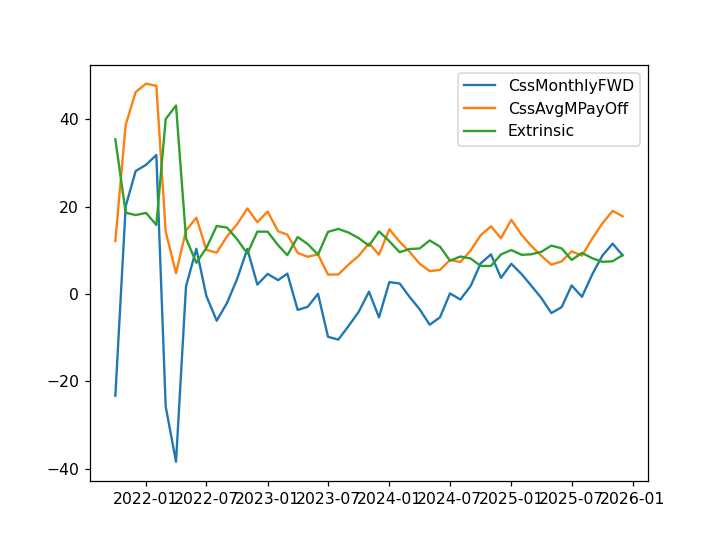

In [429]:
import matplotlib.pyplot as plt

%matplotlib notebook

plt.figure()
plt.plot(CssMonthlyFWD)
plt.plot(CssAvgMPayOff)
plt.plot(df['Extrinsic'])
plt.legend(['CssMonthlyFWD','CssAvgMPayOff','Extrinsic'])

In [4]:
import pandas as pd
import glob
import os
import numpy as np
import datetime as datetime

def cleanSparkSpreadOption(date):

    def listPatternFiles(searchDir, pattern):
        files = glob.glob(os.path.join(searchDir, pattern), recursive = True)
        return files

    #Read the hourly power data:

    today = pd.to_datetime(date)
    tYear = today.year
    tMonth = today.month
    tDay = today.day

    pattern = 'Daily_'+str(tYear)+str(tMonth)+str(tDay)+'*HourlyReleveld.csv'
    searchDir = 'I:/BU Portfolio Analytics/Market Analysis/Power/Models & Tools/Merit Order/PDP/Summary Outputs/'

    HourlyData = pd.read_csv(listPatternFiles(searchDir, pattern)[0], sep = ";")

    #Process the format of daily power data and grabbing as of today-dates only:

    HourlyData['VALUEDATETIME'] = pd.to_datetime(HourlyData['VALUEDATETIME'])
    HourlyData = HourlyData[HourlyData['VALUEDATETIME'] >= pd.Timestamp(today)]
    HourlyData['day'] = [str(i.year) + '-' + str(i.month) + '-' + str(i.day) for i in HourlyData['VALUEDATETIME']]

    #Read gas and carbon daily data:

    pattern = 'Daily_'+str(tYear)+str(tMonth)+str(tDay)+'*BASE CASE_Daily.csv'
    gasAndCarbon = pd.read_csv(listPatternFiles(searchDir, pattern)[0], sep = ";")

    #Process the format of gas and carbon data and grabbing as of today-dates only:

    gasAndCarbon['VALUEDATETIME'] = pd.to_datetime(gasAndCarbon['VALUEDATETIME'])
    gasAndCarbon = gasAndCarbon[gasAndCarbon['VALUEDATETIME'] >= pd.Timestamp(today)]

    #Creating separated dataframes for Carbon and gas from the previous dataframe, setting their index and rejoining them to exclude COAL:

    carbonList = ['CARBON_Sim_'+str(i) for i in range(1,501)]
    gasList = ['GAS_Sim_'+str(i) for i in range(1,501)]
    carbonData = gasAndCarbon[carbonList]
    gasData = gasAndCarbon[gasList]
    carbonData.index = gasAndCarbon['VALUEDATETIME']
    gasData.index = gasAndCarbon['VALUEDATETIME']
    gasAndCarbon = gasData.join(carbonData)

    #Joining the dataframes to transform gas and carbon data in hourly granularity data:

    data = pd.merge(left=HourlyData,
                    right=gasAndCarbon,
                    how='left',
                    left_on = 'VALUEDATETIME',
                    right_on='VALUEDATETIME')
    data = data.fillna(method='ffill')

    #Creating three separated dataframes again for power, gas and CO2:

    powerList = ['POWERPRICES_NL_Sim_'+ str(i) for i in range(1,501)]
    carbonData = data[carbonList]
    gasData = data[gasList]
    powerData = data[powerList]
    carbonData.index, gasData.index, powerData.index = (data['VALUEDATETIME'] for i in range(1,4))

    #Creating hourly CSS simulations

    CssHourly = pd.DataFrame(powerData.values - 1.91900818*gasData.values - 0.353084*carbonData.values)

    #Giving name to columns and rows:

    CssHourly.index = powerData.index
    CssHourly.columns = ['CSS_NL_Sim_'+str(i) for i in range(1,501)]

    CssHourlyFWD = CssHourly.T.mean().T
    CssAvgHPayOff = CssHourly.where(CssHourly >0,0).T.mean().T

    #Creating data with Monthly frequency for the fwd curve:

    CssMonthlyFWD = pd.DataFrame(CssHourlyFWD)
    CssMonthlyFWD.index = pd.to_datetime(CssMonthlyFWD.index)
    CssMonthlyFWD.columns = ['ForwardCss']
    CssMonthlyFWD['Year&Month'] = [str(i.year)+'-'+str(i.month) for i in CssMonthlyFWD.index]
    CssMonthlyFWD = CssMonthlyFWD.groupby('Year&Month').agg(np.mean)
    CssMonthlyFWD.index = pd.to_datetime(CssMonthlyFWD.index)
    CssMonthlyFWD.sort_index(inplace=True)

    #Creating data with Monthly frequency for the extrinsic value:

    CssAvgMPayOff=pd.DataFrame(CssAvgHPayOff)
    CssAvgMPayOff.index = pd.to_datetime(CssAvgMPayOff.index)
    CssAvgMPayOff.columns = ['OptionCss']
    CssAvgMPayOff['Year&Month'] = [str(i.year)+'-'+str(i.month) for i in CssAvgMPayOff.index]
    CssAvgMPayOff = CssAvgMPayOff.groupby('Year&Month').agg(np.mean)
    CssAvgMPayOff.index = pd.to_datetime(CssAvgMPayOff.index)
    CssAvgMPayOff.sort_index(inplace=True)

    #Creating DataFrame with option value, fwd and extrinsic:

    df = pd.DataFrame({'Forward': pd.Series(CssMonthlyFWD['ForwardCss']),
                 'Option_value':pd.Series(CssAvgMPayOff['OptionCss']),
                 'Extrinsic':pd.Series(CssAvgMPayOff['OptionCss']-CssMonthlyFWD['ForwardCss'])})

    #Save it as a csv:

    df.to_csv('C:/Users/D110148/OneDrive - pzem/data/CssExtrinsic'+str(tYear)+str(tMonth)+str(tDay)+'.csv')
    
    return df

In [5]:
data = cleanSparkSpreadOption('2021-09-26')

IndexError: list index out of range

In [2]:
data

,Forward_CSS,Forward_Option_Css,Forward_Intr,Forward_Extrinsic
Year&Month,,,,
2021-10-01,-19.924812,0.415142,0.134655,0.280488
2021-11-01,23.481622,33.642595,31.908864,1.733731
2021-12-01,31.539182,41.975222,35.958359,6.016863
2022-01-01,32.943028,43.726022,35.796322,7.929700
2022-02-01,35.194696,43.465339,36.212893,7.252447
2022-03-01,-22.597560,4.695853,0.000000,4.695853
2022-04-01,-35.859233,0.263311,0.000000,0.263311
2022-05-01,3.625246,12.490120,10.383284,2.106836
2022-06-01,11.927021,16.524567,15.115143,1.409424


In [19]:
#CODE FOR DAILY BASELOAD CSS OPTION VALUATION


import pandas as pd
import glob
import os
import numpy as np
import datetime as datetime

def listPatternFiles(searchDir, pattern):
    files = glob.glob(os.path.join(searchDir, pattern), recursive = True)
    return files

#Read the hourly power data:

today = pd.to_datetime('2021-09-25')
tYear = today.year
tMonth = today.month
tDay = today.day

strMonth = ''
strDay = ''

if len(str(tMonth)) < 2:
    strMonth = '0'+str(tMonth)
else:
    strMonth = str(tMonth)
    
if len(str(tDay)) < 2:
    strDay = '0'+str(tDay)
else:
    strDay = str(tDay)
    

pattern = 'Daily_'+str(tYear)+strMonth+strDay+'*HourlyReleveld.csv'
searchDir = 'I:/BU Portfolio Analytics/Market Analysis/Power/Models & Tools/Merit Order/PDP/Summary Outputs/'

HourlyData = pd.read_csv(listPatternFiles(searchDir, pattern)[0], sep = ";")

#Process the format and transform it to daily data:

HourlyData['VALUEDATETIME'] = pd.to_datetime(HourlyData['VALUEDATETIME'])
HourlyData = HourlyData[HourlyData['VALUEDATETIME'] >= pd.Timestamp(today)]
HourlyData['day'] = [str(i.year) + '-' + str(i.month) + '-' + str(i.day) for i in HourlyData['VALUEDATETIME']]
HourlyData = HourlyData.groupby('day').agg(np.mean)
HourlyData.index = pd.to_datetime(HourlyData.index)
HourlyData.sort_index(inplace = True)

#Read gas and carbon daily data:

pattern = 'Daily_'+str(tYear)+strMonth+strDay+'*BASE CASE_Daily.csv'
    
gasAndCarbon = pd.read_csv(listPatternFiles(searchDir, pattern)[0], sep = ";")

#Process the format:

gasAndCarbon['VALUEDATETIME'] = pd.to_datetime(gasAndCarbon['VALUEDATETIME'])
gasAndCarbon = gasAndCarbon[gasAndCarbon['VALUEDATETIME'] >= pd.Timestamp(today)]

#Creating separated dataframes for Carbon and gas from the previous dataframe and setting their index:

carbonList = ['CARBON_Sim_'+str(i) for i in range(1,501)]
gasList = ['GAS_Sim_'+str(i) for i in range(1,501)]
carbonData = gasAndCarbon[carbonList]
gasData = gasAndCarbon[gasList]
carbonData.index, gasData.index = (gasAndCarbon['VALUEDATETIME'] for i in range(1,3))

#Creating CSS database:

CssDaily = pd.DataFrame(HourlyData.values - gasData.values/0.5305 - 0.3468*carbonData.values)
CssDaily.columns = ['CSS_NL_Sim_'+str(i) for i in range(1,501)]
CssDaily.index = HourlyData.index
CssDaily['Year&Month'] = [str(i.year)+ '-' + str(i.month) for i in CssDaily.index]

#Creating CSS fwd curve:

CssMonthlyFWD=CssDaily.groupby('Year&Month').agg(np.mean).T.mean().T
CssMonthlyFWD.index = pd.to_datetime(CssMonthlyFWD.index)
CssMonthlyFWD.sort_index(inplace = True)

#Creating CSS fwd option value:

CssDaily = CssDaily.iloc[:,:-1]
CssDailyOption = pd.DataFrame(CssDaily.where(CssDaily > 0,0))
CssDailyOption['Year&Month'] = [str(i.year)+'-'+str(i.month) for i in CssDailyOption.index]
CssOptMonthly = CssDailyOption.groupby('Year&Month').agg(np.mean)
CssOptMonthly.index = pd.to_datetime(CssOptMonthly.index)
CssOptMonthly.sort_index(inplace = True)
CssOptMonthly = CssOptMonthly.T.mean().T

#Creating Monthly intrinsic:

CssDailyAvg = CssDaily.T.mean()
CssDailyIntr = pd.DataFrame(CssDailyAvg.where(CssDailyAvg>0,0))
CssDailyIntr['Year&Month'] = [str(i.year) + '-' +str(i.month) for i in CssDailyIntr.index]
CssMonthlyIntr=CssDailyIntr.groupby('Year&Month').agg(np.mean)
CssMonthlyIntr.index = pd.to_datetime(CssMonthlyIntr.index)
CssMonthlyIntr.sort_index(inplace=True)
CssMonthlyIntr = pd.Series(CssMonthlyIntr[0])
                              
#Creating Final Data Frame:

data = pd.DataFrame({'Forward_CSS': CssMonthlyFWD,
              'Forward_Option_Css':CssOptMonthly,
                     'Forward_Intr':CssMonthlyIntr,
              'Forward_Extrinsic':CssOptMonthly - CssMonthlyIntr})

#Saving CSV:

data.to_csv('C:/Users/D110148/OneDrive - pzem/data/CSSExtrinsicMODaily'+str(tYear)+str(tMonth)+str(tDay)+'2.csv')



Short month


In [3]:
#CODE FOR DAILY BASELOAD CSS OPTION VALUATION FUNCTION

def DailyCssOptionValuation(date):

    import pandas as pd
    import glob
    import os
    import numpy as np
    import datetime as datetime

    def listPatternFiles(searchDir, pattern):
        files = glob.glob(os.path.join(searchDir, pattern), recursive = True)
        return files

    #Read the hourly power data:

    today = pd.to_datetime(date)
    tYear = today.year
    tMonth = today.month
    tDay = today.day
    
    strMonth = ''
    strDay = ''

    if len(str(tMonth)) < 2:
        strMonth = '0'+str(tMonth)
    else:
        strMonth = str(tMonth)

    if len(str(tDay)) < 2:
        strDay = '0'+str(tDay)
    else:
        strDay = str(tDay)

    pattern = 'Daily_'+str(tYear)+strMonth+strDay+'*HourlyReleveld.csv'    
    searchDir = 'I:/BU Portfolio Analytics/Market Analysis/Power/Models & Tools/Merit Order/PDP/Summary Outputs/'

    HourlyData = pd.read_csv(listPatternFiles(searchDir, pattern)[0], sep = ";")

    #Process the format and transform it to daily data:

    HourlyData['VALUEDATETIME'] = pd.to_datetime(HourlyData['VALUEDATETIME'])
    HourlyData = HourlyData[HourlyData['VALUEDATETIME'] >= pd.Timestamp(today)]
    HourlyData['day'] = [str(i.year) + '-' + str(i.month) + '-' + str(i.day) for i in HourlyData['VALUEDATETIME']]
    HourlyData = HourlyData.groupby('day').agg(np.mean)
    HourlyData.index = pd.to_datetime(HourlyData.index)
    HourlyData.sort_index(inplace = True)

    #Read gas and carbon daily data:

    pattern = 'Daily_'+str(tYear)+strMonth+strDay+'*BASE CASE_Daily.csv'
    gasAndCarbon = pd.read_csv(listPatternFiles(searchDir, pattern)[0], sep = ";")

    #Process the format:

    gasAndCarbon['VALUEDATETIME'] = pd.to_datetime(gasAndCarbon['VALUEDATETIME'])
    gasAndCarbon = gasAndCarbon[gasAndCarbon['VALUEDATETIME'] >= pd.Timestamp(today)]

    #Creating separated dataframes for Carbon and gas from the previous dataframe and setting their index:

    carbonList = ['CARBON_Sim_'+str(i) for i in range(1,501)]
    gasList = ['GAS_Sim_'+str(i) for i in range(1,501)]
    carbonData = gasAndCarbon[carbonList]
    gasData = gasAndCarbon[gasList]
    carbonData.index, gasData.index = (gasAndCarbon['VALUEDATETIME'] for i in range(1,3))

    #Creating CSS database (the efficiency is understated, but this happened to be conservative):

    CssDaily = pd.DataFrame(HourlyData.values - 1.91900818*gasData.values - 0.353084*carbonData.values)
    CssDaily.columns = ['CSS_NL_Sim_'+str(i) for i in range(1,501)]
    CssDaily.index = HourlyData.index
    CssDaily['Year&Month'] = [str(i.year)+ '-' + str(i.month) for i in CssDaily.index]

    #Creating CSS fwd curve:

    CssMonthlyFWD=CssDaily.groupby('Year&Month').agg(np.mean).T.mean().T
    CssMonthlyFWD.index = pd.to_datetime(CssMonthlyFWD.index)
    CssMonthlyFWD.sort_index(inplace = True)

    #Creating CSS fwd option value:

    CssDaily = CssDaily.iloc[:,:-1]
    CssDailyOption = pd.DataFrame(CssDaily.where(CssDaily > 0,0))
    CssDailyOption['Year&Month'] = [str(i.year)+'-'+str(i.month) for i in CssDailyOption.index]
    CssOptMonthly = CssDailyOption.groupby('Year&Month').agg(np.mean)
    CssOptMonthly.index = pd.to_datetime(CssOptMonthly.index)
    CssOptMonthly.sort_index(inplace = True)
    CssOptMonthly = CssOptMonthly.T.mean().T
    
    #Creating Monthly intrinsic:

    CssDailyAvg = CssDaily.T.mean()
    CssDailyIntr = pd.DataFrame(CssDailyAvg.where(CssDailyAvg>0,0))
    CssDailyIntr['Year&Month'] = [str(i.year) + '-' +str(i.month) for i in CssDailyIntr.index]
    CssMonthlyIntr=CssDailyIntr.groupby('Year&Month').agg(np.mean)
    CssMonthlyIntr.index = pd.to_datetime(CssMonthlyIntr.index)
    CssMonthlyIntr.sort_index(inplace=True)
    CssMonthlyIntr = pd.Series(CssMonthlyIntr[0])

    #Creating Final Data Frame:

    data = pd.DataFrame({'Forward_CSS': CssMonthlyFWD,
                  'Forward_Option_Css':CssOptMonthly,
                         'Forward_Intr':CssMonthlyIntr,
                  'Forward_Extrinsic':CssOptMonthly - CssMonthlyIntr})

    #Saving CSV:

    data.to_csv('C:/Users/D110148/OneDrive - pzem/data/CSSExtrinsicMODaily'+str(tYear)+str(tMonth)+str(tDay)+'.csv')
    
    return data


In [5]:
DailyCssOptionValuation('2022-01-13')

,Forward_CSS,Forward_Option_Css,Forward_Intr,Forward_Extrinsic
Year&Month,,,,
2022-01-01,15.199906,19.087581,16.962995,2.124586
2022-02-01,23.273890,29.917802,25.677687,4.240115
2022-03-01,4.881487,15.856612,11.718679,4.137933
2022-04-01,5.218752,17.221014,14.724813,2.496201
2022-05-01,0.373777,15.452338,11.272335,4.180003
2022-06-01,-3.104568,13.799334,8.895501,4.903833
2022-07-01,-3.484239,11.860362,7.576754,4.283608
2022-08-01,4.155145,15.975416,11.705199,4.270217
2022-09-01,14.174062,22.421623,19.261850,3.159773


In [16]:
len(str(tMonth))

1